In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import f1_score, classification_report, average_precision_score, precision_recall_curve, multilabel_confusion_matrix

In [2]:
model = tf.keras.models.load_model("model_1.keras")

In [3]:
X_test = np.load('X_test_normalized.npy')
y_test = np.load('y_test.npy', allow_pickle=True)

X_val = np.load('X_val_normalized.npy')
y_val = np.load('y_val.npy', allow_pickle=True)

In [4]:
y_prob_val  = model.predict(X_val)
y_prob_test = model.predict(X_test)

thresholds = []
for j in range(y_val.shape[1]):
    precision, recall, th = precision_recall_curve(y_val[:, j], y_prob_val[:, j])
    f1 = 2*precision*recall / (precision + recall + 1e-12)
    best = np.argmax(f1)
    best_t = th[best] if best < len(th) else 0.5
    thresholds.append(best_t)

y_pred_test = (y_prob_test >= thresholds).astype(int)

print("Micro F1:", f1_score(y_test, y_pred_test, average="micro", zero_division=0))
print("Macro F1:", f1_score(y_test, y_pred_test, average="macro", zero_division=0))

# Per-class report
print(classification_report(y_test, y_pred_test, target_names=["NORM","MI","STTC","CD","HYP"], zero_division=0))

# Per-class PR-AUC (Average Precision)
ap = average_precision_score(y_test, y_prob_test, average=None)
for name, val in zip(["NORM","MI","STTC","CD","HYP"], ap):
    print(name, "AP:", val)

69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
Micro F1: 0.734181568088033
Macro F1: 0.7002059666657837
              precision    recall  f1-score   support

        NORM       0.80      0.87      0.83       963
          MI       0.67      0.72      0.69       550
        STTC       0.65      0.81      0.72       521
          CD       0.71      0.66      0.69       496
         HYP       0.56      0.58      0.57       262

   micro avg       0.71      0.76      0.73      2792
   macro avg       0.68      0.73      0.70      2792
weighted avg       0.71      0.76      0.73      2792
 samples avg       0.72      0.76      0.72      2792

NORM AP: 0.9035833356059557
MI AP: 0.7725063698650277
STTC AP: 0.7616970133117167
CD AP: 0.7628491472770269
HYP AP: 0.6019095981039861


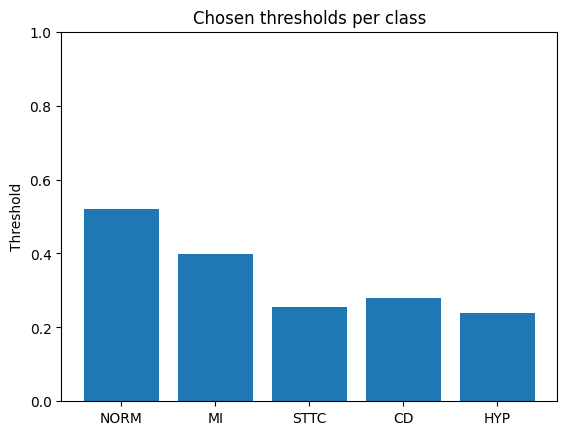

In [5]:
# A) thresholds bar
class_names = ["NORM","MI","STTC","CD","HYP"]

plt.figure()
plt.bar(class_names, thresholds)
plt.ylim(0, 1)
plt.title("Chosen thresholds per class")
plt.ylabel("Threshold")
plt.savefig("threshold.png")
plt.show()

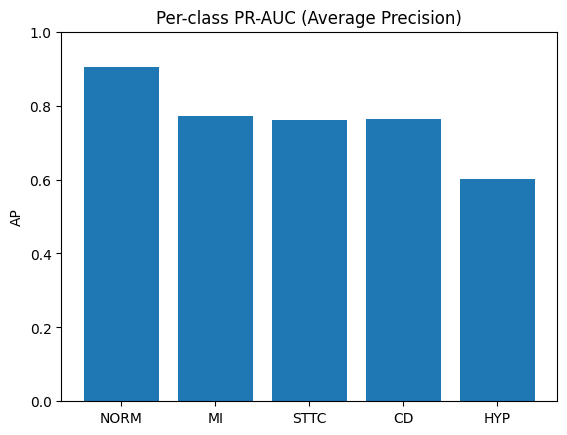

In [6]:
# B) AP bar
plt.figure()
plt.bar(class_names, ap)
plt.ylim(0, 1)
plt.title("Per-class PR-AUC (Average Precision)")
plt.ylabel("AP")
plt.savefig("PR-AUC (bar).png")
plt.show()

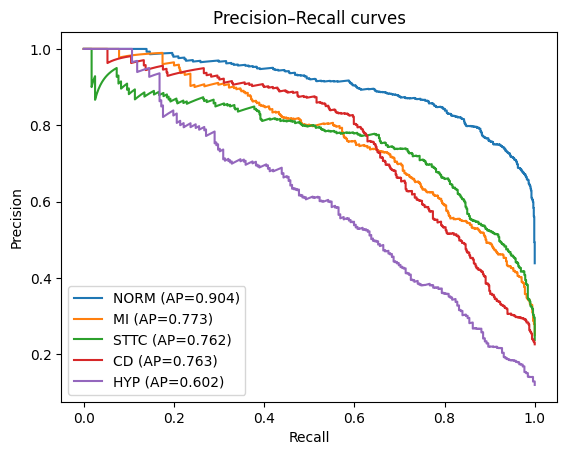

In [7]:
# C) PR curves per class (test)
plt.figure()
for j, name in enumerate(class_names):
    p, r, _ = precision_recall_curve(y_test[:, j], y_prob_test[:, j])
    ap_j = average_precision_score(y_test[:, j], y_prob_test[:, j])
    plt.plot(r, p, label=f"{name} (AP={ap_j:.3f})")
plt.title("Precision–Recall curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.savefig("PR-AUC curves.png")
plt.show()

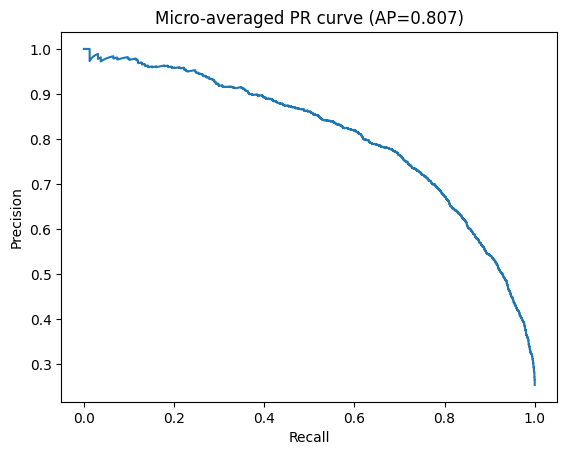

In [8]:
# D) Micro-averaged PR curve (flatten all labels)
p_micro, r_micro, _ = precision_recall_curve(y_test.ravel(), y_prob_test.ravel())
ap_micro = average_precision_score(y_test.ravel(), y_prob_test.ravel())
plt.figure()
plt.plot(r_micro, p_micro)
plt.title(f"Micro-averaged PR curve (AP={ap_micro:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.savefig("Micro-Averaged PR curve.png")
plt.show()

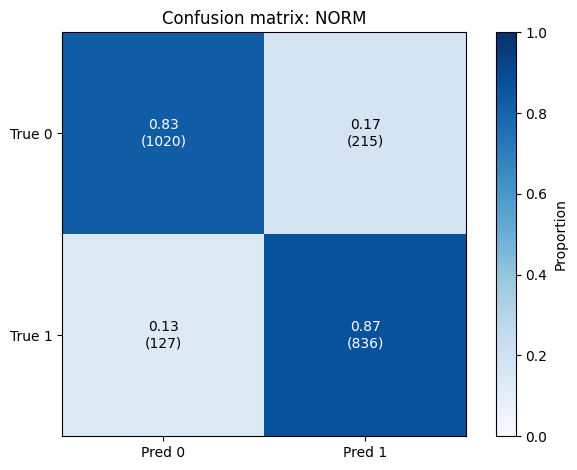

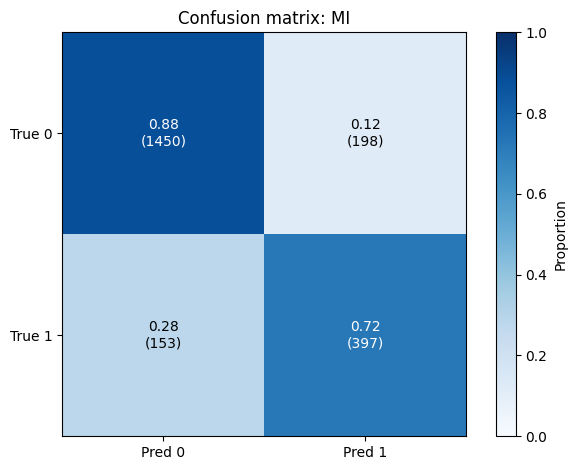

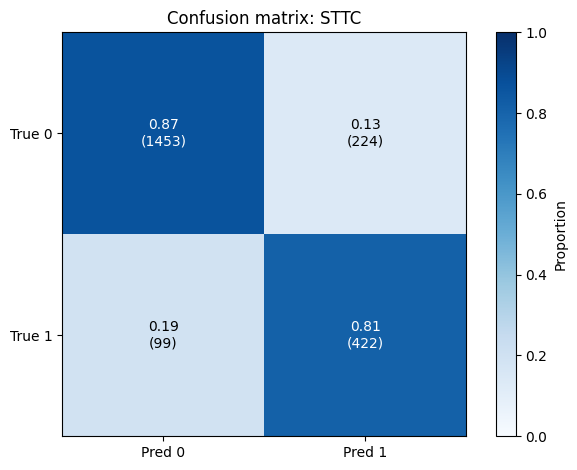

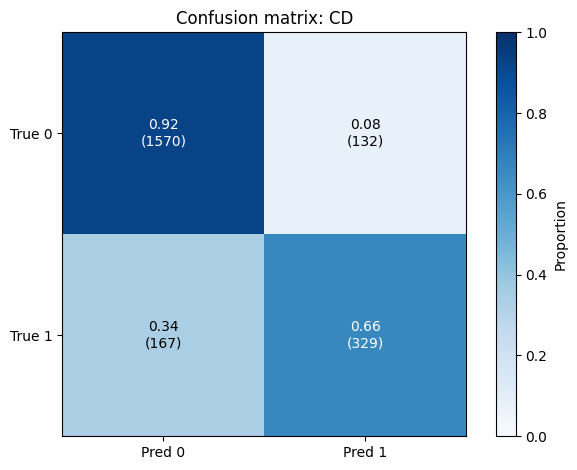

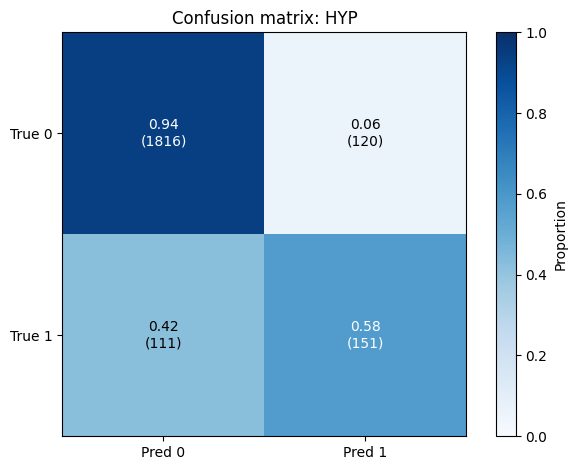

In [9]:
# E) Confusion Matrix
mcm = multilabel_confusion_matrix(y_test, y_pred_test)

for j, name in enumerate(class_names):
    cm = mcm[j].astype(float)  # [[tn, fp],[fn, tp]]

    # Normalize by true class (row-wise) so plots are comparable
    row_sums = cm.sum(axis=1, keepdims=True)
    cm_norm = np.divide(cm, row_sums, out=np.zeros_like(cm), where=row_sums!=0)

    fig, ax = plt.subplots()
    im = ax.imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)

    ax.set_title(f"Confusion matrix: {name}")
    ax.set_xticks([0, 1]); ax.set_xticklabels(["Pred 0", "Pred 1"])
    ax.set_yticks([0, 1]); ax.set_yticklabels(["True 0", "True 1"])

    # Text: show both normalized + raw counts
    for (i, k), _ in np.ndenumerate(cm_norm):
        val = cm_norm[i, k]
        raw = int(mcm[j][i, k])
        ax.text(k, i, f"{val:.2f}\n({raw})",
                ha="center", va="center",
                color="white" if val > 0.5 else "black")

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Proportion")
    plt.tight_layout()
    plt.savefig("Confusion Matrix.png")
    plt.show()

In [10]:
def _to_tensor(x):
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    return x

def predict_one(x1):
    """x1: (1, T, L)"""
    return model(x1, training=False).numpy()[0]

def saliency_vanilla(x1, class_idx):
    """
    Vanilla gradient saliency: |d(score)/dx|
    x1: (1, T, L)
    """
    x = _to_tensor(x1)
    with tf.GradientTape() as tape:
        tape.watch(x)
        y = model(x, training=False)[:, class_idx]  # (1,)
    grads = tape.gradient(y, x)  # (1,T,L)
    sal = tf.abs(grads)[0].numpy()  # (T,L)
    return sal

def saliency_smoothgrad(x1, class_idx, n_samples=30, noise_sigma=0.10):
    """
    SmoothGrad: average vanilla gradients over noisy inputs.
    noise_sigma is fraction of per-sample std.
    """
    x = x1.astype(np.float32)
    std = np.std(x)
    sigma = noise_sigma * (std + 1e-8)

    acc = 0.0
    for _ in range(n_samples):
        xn = x + np.random.normal(0, sigma, size=x.shape).astype(np.float32)
        acc += saliency_vanilla(xn, class_idx)
    return acc / n_samples

def saliency_integrated_gradients(x1, class_idx, steps=50, baseline=None):
    """
    Integrated Gradients for multi-label score y[:, class_idx].
    baseline default: zeros.
    """
    x = x1.astype(np.float32)
    if baseline is None:
        baseline = np.zeros_like(x, dtype=np.float32)

    # Interpolate inputs between baseline and x
    alphas = np.linspace(0.0, 1.0, steps).astype(np.float32)
    ig_acc = np.zeros_like(x[0], dtype=np.float32)  # (T,L)

    for a in alphas:
        xa = baseline + a * (x - baseline)  # (1,T,L)
        xa_t = _to_tensor(xa)
        with tf.GradientTape() as tape:
            tape.watch(xa_t)
            y = model(xa_t, training=False)[:, class_idx]
        grads = tape.gradient(y, xa_t)[0].numpy()  # (T,L)
        ig_acc += grads

    ig_avg = ig_acc / steps
    ig = (x[0] - baseline[0]) * ig_avg  # elementwise
    return np.abs(ig)

def normalize_map(m, eps=1e-8):
    m = m.astype(np.float32)
    m = m - m.min()
    m = m / (m.max() + eps)
    return m

def plot_heatmap_ecg(x1, sal_map, title="", lead_names=None):
    """
    x1: (1,T,L), sal_map: (T,L)
    """
    x = x1[0]
    T, L = x.shape
    if lead_names is None:
        lead_names = [f"Lead{i+1}" for i in range(L)]

    sal_n = normalize_map(sal_map)

    plt.figure(figsize=(12, 4))
    plt.imshow(sal_n.T, aspect="auto", origin="lower")
    plt.yticks(np.arange(L), lead_names)
    plt.xlabel("Time")
    plt.ylabel("Lead")
    plt.title(title)
    plt.colorbar(label="Normalized importance")
    plt.tight_layout()
    plt.show()

def plot_overlay_onelead(x1, sal_map, lead=0, title=""):
    """
    Quick sanity overlay: one lead signal + saliency intensity under it.
    """
    x = x1[0][:, lead]
    s = normalize_map(sal_map[:, lead])

    plt.figure(figsize=(12, 3))
    plt.plot(x, linewidth=1)
    # draw a soft importance band (no fancy styling)
    plt.fill_between(np.arange(len(x)), x.min(), x.min() + s*(x.max()-x.min()), alpha=0.35)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

Pred probs:
NORM : 0.7083
MI   : 0.2209
STTC : 0.0063
CD   : 0.0623
HYP  : 0.0143
Explaining: NORM


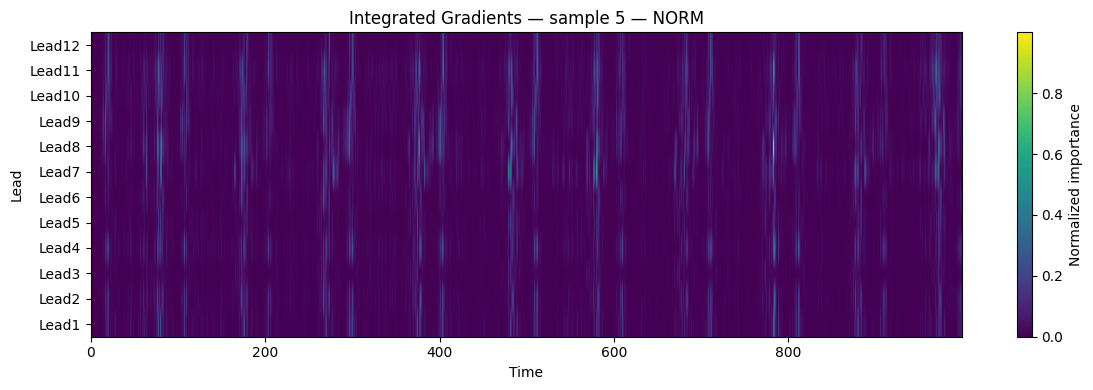

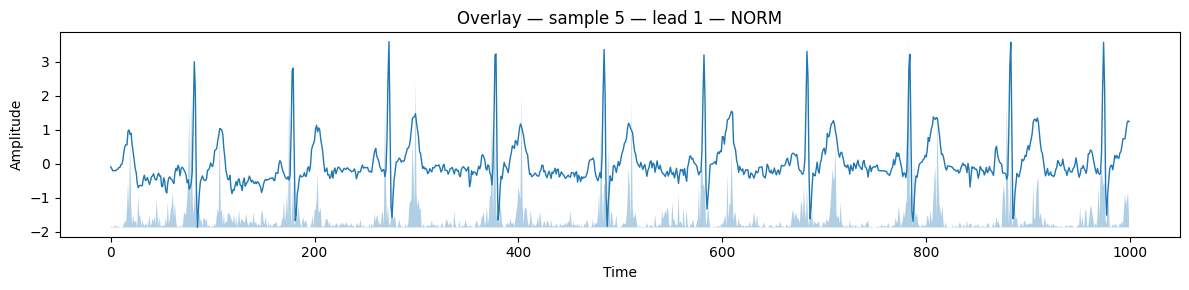

In [27]:
i = 5  # pick any index
x1 = X_test[i:i+1]  # (1,T,L)
probs = predict_one(x1)

print("Pred probs:")
for k, name in enumerate(class_names):
    print(f"{name:5s}: {probs[k]:.4f}")

# Pick a class to explain (e.g., the top predicted class)
#class_idx = int(np.argmax(probs))
class_idx = 0
print("Explaining:", class_names[class_idx])

# IG
sal_ig = saliency_integrated_gradients(x1, class_idx, steps=50)

plot_heatmap_ecg(x1, sal_ig, title=f"Integrated Gradients — sample {i} — {class_names[class_idx]}")

# overlay on one lead (e.g., lead 0)
plot_overlay_onelead(x1, sal_ig, lead=0, title=f"Overlay — sample {i} — lead 1 — {class_names[class_idx]}")

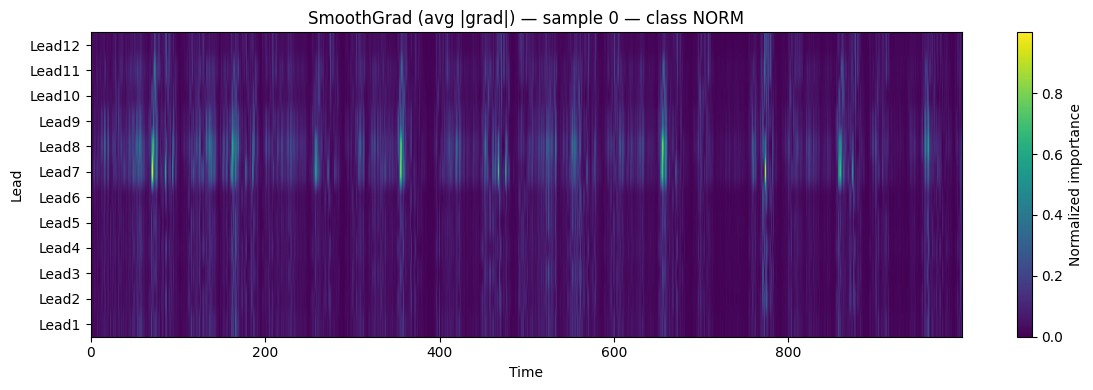

In [19]:
# SmoothGrad

sal_sg = saliency_smoothgrad(x1, class_idx, n_samples=30, noise_sigma=0.10)
plot_heatmap_ecg(
    x1, sal_sg,
    title=f"SmoothGrad (avg |grad|) — sample {i} — class {class_names[class_idx]}"
)

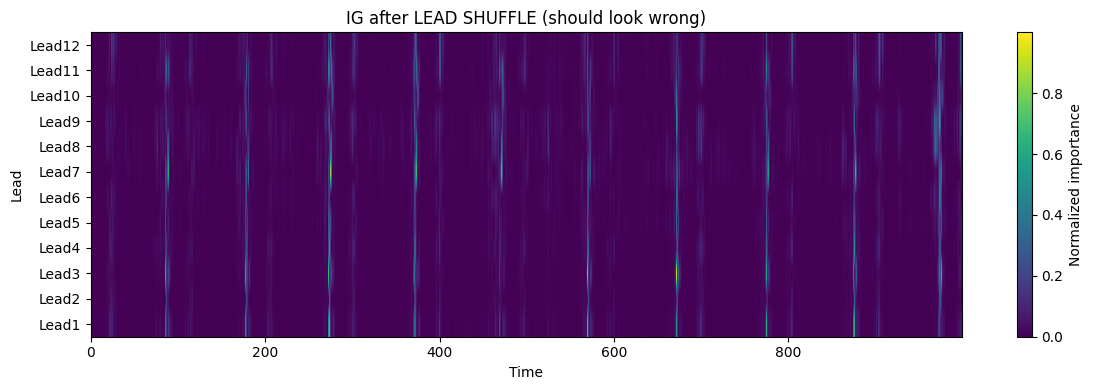

In [15]:
x_shuf = x1.copy()
x_shuf[0] = x_shuf[0][:, np.random.permutation(x_shuf.shape[-1])]
sal_shuf = saliency_integrated_gradients(x_shuf, class_idx, steps=50)
plot_heatmap_ecg(x_shuf, sal_shuf, title="IG after LEAD SHUFFLE (should look wrong)")